In [50]:
%reload_ext autoreload
%autoreload 2

In [51]:
from typing import List

import numpy as np
import pytest
import torch
from scipy.stats import gaussian_kde
from torch import eye, ones, zeros
from torch.distributions import MultivariateNormal

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.analysis import conditional_potential
from sbi.inference import (
    FMPE,
    NPSE,
    MCMCPosterior,
    VectorFieldPosterior,
    simulate_for_sbi,
    vector_field_estimator_based_potential,
)
from sbi.simulators import linear_gaussian
from sbi.simulators.linear_gaussian import (
    samples_true_posterior_linear_gaussian_mvn_prior_different_dims,
    samples_true_posterior_linear_gaussian_uniform_prior,
    true_posterior_linear_gaussian_mvn_prior,
)
from sbi.utils import BoxUniform
from sbi.utils.metrics import check_c2st
from sbi.utils.user_input_checks import process_simulator


# ------------------------------------------------------------------------------
# ------------------------------- FAST TESTS -----------------------------------
# ------------------------------------------------------------------------------


# We always test num_dim and sample_with with defaults and mark the rests as slow.
@pytest.mark.parametrize(
    "vector_field_type, num_dim, prior_str, sample_with",
    [
        ("vp", 1, "gaussian", ["sde", "ode"]),
        ("vp", 3, "uniform", ["sde", "ode"]),
        ("vp", 3, "gaussian", ["sde", "ode"]),
        ("ve", 3, "uniform", ["sde", "ode"]),
        ("subvp", 3, "uniform", ["sde", "ode"]),
        ("fmpe", 1, "gaussian", ["sde", "ode"]),
        ("fmpe", 1, "uniform", ["sde", "ode"]),
        ("fmpe", 3, "gaussian", ["sde", "ode"]),
        ("fmpe", 3, "uniform", ["sde", "ode"]),
    ],
)
def test_c2st_vector_field_on_linearGaussian(
    vector_field_type, num_dim: int, prior_str: str, sample_with: List[str]
):
    """
    Test whether NPSE and FMPE infer well a simple example with available ground truth.
    """

    x_o = zeros(1, num_dim)
    num_samples = 1000
    num_simulations = 10_000

    # likelihood_mean will be likelihood_shift+theta
    likelihood_shift = -1.0 * ones(num_dim)
    likelihood_cov = 0.3 * eye(num_dim)

    if prior_str == "gaussian":
        prior_mean = zeros(num_dim)
        prior_cov = eye(num_dim)
        prior = MultivariateNormal(loc=prior_mean, covariance_matrix=prior_cov)
        gt_posterior = true_posterior_linear_gaussian_mvn_prior(
            x_o, likelihood_shift, likelihood_cov, prior_mean, prior_cov
        )
        target_samples = gt_posterior.sample((num_samples,))
    else:
        prior = utils.BoxUniform(-2.0 * ones(num_dim), 2.0 * ones(num_dim))
        target_samples = samples_true_posterior_linear_gaussian_uniform_prior(
            x_o,
            likelihood_shift,
            likelihood_cov,
            prior=prior,
            num_samples=num_samples,
        )
    if vector_field_type == "fmpe":
        inference = FMPE(prior, show_progress_bars=True)
    else:
        inference = NPSE(prior, sde_type=vector_field_type, show_progress_bars=True)

    theta = prior.sample((num_simulations,))
    x = linear_gaussian(theta, likelihood_shift, likelihood_cov)

    score_estimator = inference.append_simulations(theta, x).train(
        training_batch_size=100,
        max_num_epochs=50,
    )
    # amortize the training when testing sample_with.
    for method in sample_with:
        posterior = inference.build_posterior(
            score_estimator,
            sample_with=method,
            neural_ode_backend="zuko",
        )
        posterior.set_default_x(x_o)
        samples = posterior.sample((num_samples,))

        # Compute the c2st and assert it is near chance level of 0.5.
        check_c2st(
            samples,
            target_samples,
            alg=f"vector_field-{vector_field_type}-{prior_str}-{num_dim}D-{method}",
            tol=0.15 if method == "ode" else 0.1,  # ODE with scores is less accurate
        )

    # Checks for log_prob()
    if prior_str == "gaussian":
        # For the Gaussian prior, we compute the KLd between ground truth and
        # posterior.

        # Disable exact integration for the ODE solver to speed up the computation.
        posterior.potential_fn.neural_ode.update_params(
            exact=False,
            atol=1e-4,
            rtol=1e-4,
        )
        dkl = get_dkl_gaussian_prior(
            posterior,
            x_o[0],
            likelihood_shift,
            likelihood_cov,
            prior_mean,
            prior_cov,
        )

        max_dkl = 0.15

        assert dkl < max_dkl, (
            f"D-KL={dkl} is more than 2 stds above the average performance."
        )


In [72]:
vector_field_type = "ve"
num_dim = 3
prior_str = "uniform"
sample_with = "sde"


x_o = zeros(1, num_dim)
num_samples = 1000
num_simulations = 100_000

# likelihood_mean will be likelihood_shift+theta
likelihood_shift = -1.0 * ones(num_dim)
likelihood_cov = 0.3 * eye(num_dim)

if prior_str == "gaussian":
    prior_mean = zeros(num_dim)
    prior_cov = eye(num_dim)
    prior = MultivariateNormal(loc=prior_mean, covariance_matrix=prior_cov)
    gt_posterior = true_posterior_linear_gaussian_mvn_prior(
        x_o, likelihood_shift, likelihood_cov, prior_mean, prior_cov
    )
    target_samples = gt_posterior.sample((num_samples,))
else:
    prior = utils.BoxUniform(-2.0 * ones(num_dim), 2.0 * ones(num_dim))
    target_samples = samples_true_posterior_linear_gaussian_uniform_prior(
        x_o,
        likelihood_shift,
        likelihood_cov,
        prior=prior,
        num_samples=num_samples,
    )
if vector_field_type == "fmpe":
    inference = FMPE(prior, show_progress_bars=True)
else:
    inference = NPSE(prior, sde_type=vector_field_type, show_progress_bars=True)

theta = prior.sample((num_simulations,))
x = linear_gaussian(theta, likelihood_shift, likelihood_cov)

score_estimator = inference.append_simulations(theta, x).train(training_batch_size=5000, max_num_epochs=100)


 Training neural network. Epochs trained: 33

KeyboardInterrupt: 

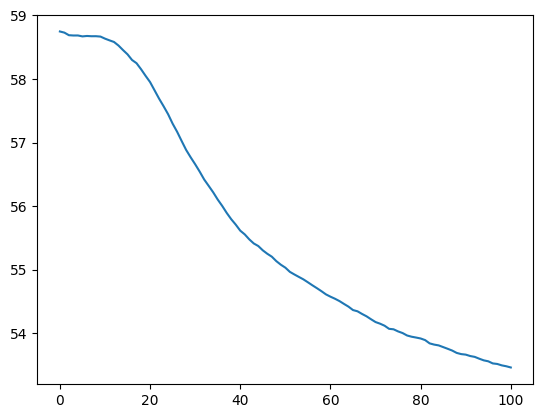

In [71]:
import matplotlib.pyplot as plt
plt.plot(inference.summary["validation_loss"])

In [69]:
posterior = inference.build_posterior(
    score_estimator,
    sample_with="ode",
    neural_ode_backend="zuko",
)
posterior.set_default_x(x_o)
samples = posterior.sample((num_samples,))

from sbi.utils.metrics import c2st

c2st(samples, target_samples)

Drawing 1000 posterior samples for 1 observations:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor(0.5495, dtype=torch.float64)

In [6]:
from sbi.neural_nets.factory import posterior_score_nn

In [7]:
score_estimator = posterior_score_nn(
    net="transformer",
    sde_type="vp",
)(theta, x)


In [15]:
score_estimator.net(theta, x, torch.ones((x.shape[0],)))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2000x5 and 128x128)

In [ ]:
score_estimator

In [ ]:

params = score_estimator.parameters()
optimizer = torch.optim.Adam(params, lr=1e-3)

losses = []
for i in range(100):
    optimizer.zero_grad()
    times = torch.rand(theta.shape[0], device=theta.device)*0.99 + 0.01
    loss = score_estimator.loss(theta, x, times=times).mean()
    loss.backward()
    optimizer.step()
    print(loss.item())

13.113822937011719
13.425664901733398
12.987004280090332
11.121783256530762
11.257052421569824
13.762019157409668
11.79991340637207
11.951704978942871
11.653289794921875
13.153412818908691
13.103706359863281
15.347309112548828
12.43622875213623
12.382999420166016
12.676677703857422
12.984923362731934
12.675025939941406
11.953932762145996
14.743983268737793
12.386783599853516
10.53994369506836
10.893366813659668
11.351229667663574
13.405434608459473
13.58590030670166
10.409858703613281
13.266735076904297
11.995134353637695
14.283706665039062
12.710716247558594
14.932929039001465
12.813092231750488
12.576722145080566
10.68285083770752
13.628936767578125
13.177044868469238
13.340861320495605
12.377195358276367
13.569666862487793
14.2720947265625
12.809351921081543
13.666046142578125
12.843971252441406
12.078242301940918
14.495315551757812
13.19033432006836
14.182332038879395
14.51050853729248
11.518965721130371
13.668880462646484
13.713608741760254
13.107612609863281
13.852465629577637
13

In [ ]:
FMPE(prior)

In [12]:
thetas.shape

torch.Size([1, 10, 10])

In [13]:
net(thetas, xs, torch.ones((10,))).shape


Cond_emb torch.Size([10, 34])
Input_layer Linear(in_features=34, out_features=100, bias=True)


torch.Size([1, 10, 10])

In [31]:
thetas = torch.randn((1000, 10))
xs = torch.ones((1000, 10))
score_est = posterior_score_nn(
    sde_type="vp",
    net=DummyNet(),
    embedding_net=torch.nn.Identity(),
)(thetas, xs)

In [41]:
score_est(torch.ones((1, 10)), torch.ones((1, 10)), torch.ones((1,)))

tensor([[-0.9996, -1.0026, -0.9992, -1.0046, -0.9968, -1.0009, -1.0007, -0.9986,
         -0.9986, -0.9951]])

In [ ]:
score_est.net(thetas, xs, torch.ones((1000, 1))).shape

Cond_emb torch.Size([1000, 18])
Input_layer Linear(in_features=18, out_features=100, bias=True)


torch.Size([1000, 10])